# Parse Data
Read the data out of a ZIP file and put it into a Pandas dataframe. Also compute some basic stastitics

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from zipfile import ZipFile, ZipInfo
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

## List the Contents of the ZIP File
To see what we're working with

In [2]:
datazip = ZipFile('video_voids_size.zip')

Find all the CSV files

In [3]:
csv_files = [i for i in datazip.infolist() if i.filename.endswith('csv')]
print(f'Found {len(csv_files)} CSV files')

Found 1994 CSV files


Print the head of one

In [4]:
x = csv_files[0]

In [5]:
with datazip.open(x, 'r') as fp:
    data = pd.read_csv(fp)

In [6]:
data.head()

,void id,void size (nm)
0,1,20.115950
1,2,14.948362
2,3,25.863647
3,4,25.696962
4,5,25.275441


We have an inventory of each void found during the search

## Load in All of the Datasets
Record the void sizes for each frame, along with the frame number

In [7]:
def parse_void_sizes(info: ZipInfo, zipdata: ZipFile) -> np.ndarray:
    """Extract data for a single frame
    
    Args:
        info: Information about a specific file in a ZIP
        zipdata: Zip file information
    Returns:
        List of void sizes
    """
    
    with zipdata.open(info, 'r') as fp:
        return pd.read_csv(fp)['void size (nm)'].values

In [8]:
data = pd.DataFrame([
    {'frame_id': int(Path(x.filename).name[6:-4]), 'void_radii': parse_void_sizes(x, datazip)}
    for x in csv_files
])

In [9]:
data.sort_values('frame_id', inplace=True, ignore_index=True)
data.head(3)

,frame_id,void_radii
0,1,"[20.115949960445413, 14.948362455500638, 25.86..."
1,2,"[25.30376130259481, 16.840846433292995, 25.974..."
2,3,"[20.416336496974036, 19.242504387508777, 26.16..."


## Compute Statistics for Each Step
We want key statistics about the voids:
- Void Count
- Void Radius: Total, Mean, Standard Deviation
- Void Volume: Total, Mean, Standard Deviation
- Void Surface Area: Total, Mean, Standard Deviation
- Void Fraction

In [10]:
def compute_stats(radii: np.ndarray) -> dict:
    """Compute some statistics about void sizes"""
    
    # Compute the surface areas and volumes
    surf_areas = 4 * np.pi * np.power(radii, 2)
    volumes = 4 / 3 * np.pi * np.power(radii, 3)
    
    # Initialize the output
    output = {'void_count': len(radii)}
    
    # Compute some statistics
    for name, values in zip(['radius', 'surfarea', 'volume'],
                           [radii, surf_areas, volumes]):
        output[f'{name}_total'] = np.sum(values)
        output[f'{name}_mean'] = np.mean(values)
        output[f'{name}_stddev'] = np.std(values)
    return output

In [11]:
stats = pd.DataFrame(data['void_radii'].apply(compute_stats).tolist())
data = pd.concat((data, stats), axis=1)
data.head(3)

,frame_id,void_radii,void_count,radius_total,radius_mean,radius_stddev,surfarea_total,surfarea_mean,surfarea_stddev,volume_total,volume_mean,volume_stddev
0,1,"[20.115949960445413, 14.948362455500638, 25.86...",51,1159.630190,22.737847,3.434627,338904.0,6645.176471,1904.134395,2.679521e+06,52539.617723,21444.502043
1,2,"[25.30376130259481, 16.840846433292995, 25.974...",52,1175.418020,22.604193,3.563824,342180.0,6580.384615,1923.493918,2.696669e+06,51859.015468,21163.135165
2,3,"[20.416336496974036, 19.242504387508777, 26.16...",52,1161.311616,22.332916,3.876824,335736.0,6456.461538,2040.417580,2.635457e+06,50681.869873,22248.809614


## Make Diagnostic Plots
See if everything looks fine

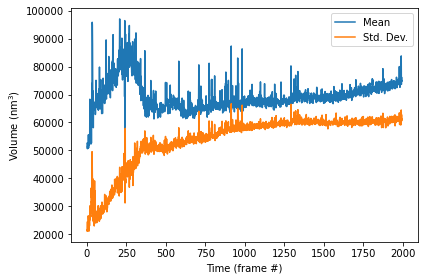

In [12]:
fig, ax = plt.subplots()

ax.plot(data['frame_id'], data['volume_mean'], label='Mean')
ax.plot(data['frame_id'], data['volume_stddev'], label='Std. Dev.')

ax.set_xlabel('Time (frame #)')
ax.set_ylabel('Volume (nm$^3$)')

ax.legend()
fig.tight_layout()

## Save the data

Save the data without the raw counts to CSV, full thing as a pickle

In [13]:
Path('datasets').mkdir(exist_ok=True)

In [14]:
data.drop(columns=['void_radii']).to_csv('datasets/initial_data.csv', index=False)

In [15]:
data.to_pickle('datasets/initial_data.pkl')